Lesson-01

In [0]:
simple_grammar="""
sentence => noun_phrase verb_phrase
noun_phrase => Article Adj* noun
Adj* => null | Adj Adj*
verb_phrase => verb noun_phrase
Article =>  一个 | 这个
noun =>   女人 |  篮球 | 桌子 | 小猫
verb => 看着   |  坐在 |  听着 | 看见
Adj =>  蓝色的 | 好看的 | 小小的
"""

In [0]:
import random

# 如何使用上面的预料生成一个句子呢？




## 基于规则的方法

### 1. 下面先从简单的生成一个形容词开始

In [0]:
def adj():  return random.choice('蓝色的 | 好看的 | 小小的'.split('|')).split()[0]

In [0]:
adj()

'小小的'

In [0]:
def adj_star():
  return random.choice([None, adj() + adj_star()])()

In [0]:
def adj_star():
  return random.choice([lambda : '',lambda : adj() + adj_star()])()

In [0]:
adj_star()

'好看的'

adj_star()的意思是可以生成多个adj() 在后面讲正则表达式的时候会提到

### 2.  **But the question is ?**

如果我们更换了语法，会发现所有写过的程序，都要重新写

#### 2.1 先以'Adj  'Adj*'  为例，假如我们要生成含有多个值的形容词

In [0]:
adj_grammar = """
Adj* => null | Adj Adj*
Adj =>  蓝色的 | 好看的 | 小小的
"""

Terminal:不能扩展，扩展的字面意思就是这个词能不能继续往下分的更细，比如
* 上面的 Adj 就可以扩展成  蓝色的 | 好看的 | 小小的 三个词；
* ’Adj*‘也可以循环往复的往下细分。

1. 下面定义一个数据结构，这个数据结构的左边可以扩展，相当于上面等号的左边，这个数据结构的右边表示它可以被扩展成什么样子。

In [0]:
grammar = {}# 左边可以扩展，右边指出如何扩展

In [0]:
for line in adj_grammar.split('\n'):
    if not line.strip():continue
  
    exp,stmt = line.split('=>')
    grammar[exp] = stmt.split('|')

In [0]:
grammar

{'Adj ': ['  蓝色的 ', ' 好看的 ', ' 小小的'], 'Adj* ': [' null ', ' Adj Adj*']}

2. 对上面的循环进行优化：去掉'Adj   ' 和'Adj *   ' 引号中后面的空格

In [0]:
grammar01 = {}

In [0]:
for line in adj_grammar.split('\n'):
    if not line.strip():continue
  
    exp,stmt = line.split('=>')
    grammar01[exp.strip()] = stmt.split('|')

In [0]:
grammar01

{'Adj': ['  蓝色的 ', ' 好看的 ', ' 小小的'], 'Adj*': [' null ', ' Adj Adj*']}

3. 继续优化：去掉所有空格

In [0]:
grammar02 = {}

In [0]:
for line in adj_grammar.split('\n'):
    if not line.strip():continue
  
    exp,stmt = line.split('=>')
    grammar02[exp.strip()] = [s.split() for s in stmt.split('|')]

In [0]:
grammar02

{'Adj': [['蓝色的'], ['好看的'], ['小小的']], 'Adj*': [['null'], ['Adj', 'Adj*']]}

In [0]:
grammar02['Adj']

[['蓝色的'], ['好看的'], ['小小的']]

In [0]:
grammar02['Adj*']

[['null'], ['Adj', 'Adj*']]

#### 2.2 现在的问题就是，怎样生成语言

1. 让机器根据输入的语法（grammar），生成一个'Adj*'，即


```
target ='Adj'
```


*   首先看'Adj*'能不能扩展
  
    *   如果可扩展，就在它所有可能的扩展中任意选择一个，可递归调用
    *   如果不可扩展，就返回自身的值

**注意**：这里的grammar是一个字典结构，Python字典中最关键的两个点是：key 和 value



In [0]:
def generate_0(gram,target):
  if target in gram : 
    new_expanded = random.choice(gram[target])
    return''.join(generate(gram,t) for t in new_expanded)
  else:
    return target

In [0]:
generate_0(gram=grammar02,target='Adj*')

'null'

2. 将上面的代码优化一下

In [0]:
def generate_1(gram,target):
  # 如果target 不在grammar中，是一个终结符，直接返回自生的值
  if target not in gram : return target # means target is a terminal expression
  # 如果在，那就随机的选择一个
  return''.join([generate(gram,t) for t in random.choice(gram[target])])

In [0]:
generate_1(gram=grammar02,target='Adj*')

'好看的'

3. 继续优化：

```
choice = random.choice

```



In [0]:
choice = random.choice
def generate_2(gram,target):
  if target not in gram : return target # means target is a terminal expression
  return''.join([generate(gram,t) for t in choice(gram[target])])

In [0]:
generate_2(gram=grammar02,target='Adj*')

'小小的'

4. 将上面的grammar数据结构抽象成一个函数

In [0]:
def create_grammar(grammar_str,split='=>'): # 输入的是grammar的字符表针
  grammar = {}
  for line in grammar_str.split('\n'):
    if not line.strip():continue
    exp,stmt = line.split(split)
    grammar[exp.strip()] = [s.split() for s in stmt.split('|')]
  return grammar

In [0]:
example_grammar = create_grammar(simple_grammar)

In [0]:
example_grammar

{'Adj': [['蓝色的'], ['好看的'], ['小小的']],
 'Adj*': [['null'], ['Adj', 'Adj*']],
 'Article': [['一个'], ['这个']],
 'noun': [['女人'], ['篮球'], ['桌子'], ['小猫']],
 'noun_phrase': [['Article', 'Adj*', 'noun']],
 'sentence': [['noun_phrase', 'verb_phrase']],
 'verb': [['看着'], ['坐在'], ['听着'], ['看见']],
 'verb_phrase': [['verb', 'noun_phrase']]}

In [0]:
generate_2(gram=example_grammar,target='sentence')

'这个篮球看见一个小猫'

5. 优化generate_2 函数，过滤'null'

In [0]:
choice = random.choice

def generate(gram,target):
  if target not in gram : return target # means target is a terminal expression
  
  expaned = [generate(gram,t) for t in choice(gram[target])] # 过滤'null'
  return''.join([e for e in expaned if e != 'null'])

第4行：首先查看target在不在gram里, 判断其是不是终结符，如果是，直接返回，

第6 行：如果不是，任意选择一个接下来要扩展的，然后把要扩展的内容再扩展一次，

第7 行：最后合并起来。

In [0]:
generate(gram=example_grammar,target='sentence')

'这个桌子坐在一个好看的桌子'

In [0]:
choice = random.choice

def generate(gram, target):
    if target not in gram: return target # means target is a terminal expression
    
    expaned = [generate(gram, t) for t in choice(gram[target])]
    return ''.join([e if e != '/n' else '\n' for e in expaned if e != 'null'])

#### 2.3 将语法更换为西部世界中的语法


In [0]:
#在西部世界里，一个”人类“的语言可以定义为：

human = """
human = 自己 寻找 活动
自己 = 我 | 俺 | 我们 
寻找 = 找找 | 想找点 
活动 = 乐子 | 玩的
"""


#一个“接待员”的语言可以定义为

host = """
host = 寒暄 报数 询问 业务相关 结尾 
报数 = 我是 数字 号 ,
数字 = 单个数字 | 数字 单个数字 
单个数字 = 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 
寒暄 = 称谓 打招呼 | 打招呼
称谓 = 人称 ,
人称 = 先生 | 女士 | 小朋友
打招呼 = 你好 | 您好 
询问 = 请问你要 | 您需要
业务相关 = 玩玩 具体业务
玩玩 = null
具体业务 = 喝酒 | 打牌 | 打猎 | 赌博
结尾 = 吗？
"""

In [0]:
print(generate(gram=create_grammar(host, split='='), target='host'))

女士,你好我是691号,请问你要赌博吗？


In [0]:
print(generate(gram=create_grammar(human, split='='), target='human'))

我想找点乐子


In [0]:
for i in range(20):
    print(generate(gram=create_grammar(host, split='='), target='host'))

小朋友,你好我是967号,请问你要打猎吗？
您好我是453256号,您需要打牌吗？
先生,您好我是9号,请问你要打牌吗？
您好我是4号,请问你要打牌吗？
小朋友,你好我是2号,您需要打牌吗？
女士,你好我是667号,您需要打猎吗？
您好我是2号,请问你要打牌吗？
您好我是8号,请问你要赌博吗？
你好我是6号,您需要赌博吗？
小朋友,你好我是8号,您需要打牌吗？
您好我是5号,您需要打猎吗？
小朋友,你好我是7号,您需要打牌吗？
您好我是6671936号,您需要喝酒吗？
你好我是8号,请问你要喝酒吗？
您好我是33号,请问你要赌博吗？
女士,你好我是31号,您需要赌博吗？
您好我是25号,请问你要赌博吗？
你好我是5377号,请问你要喝酒吗？
小朋友,你好我是43号,请问你要赌博吗？
您好我是13号,请问你要喝酒吗？


## Data Driven

我们的目标是，希望能做一个程序，然后，当输入的数据变化的时候，我们的程序不用重写。Generalization.

AI? 如何能自动化解决问题，我们找到一个方法之后，输入变了，我们的这个方法，不用变。

In [0]:
programming = """
stmt => if_exp | while_exp | assignment 
assignment => var = var
if_exp => if ( var ) { /n .... stmt }
while_exp=> while ( var ) { /n .... stmt }
var => chars number
chars => char | char char
char => student | name | info  | database | course
number => 1 | 2 | 3
"""

In [0]:
print(generate(gram=create_grammar(programming, split='=>'), target='stmt'))

infoinfo1=namedatabase3


## Language Model

![替代文字](https://render.githubusercontent.com/render/math?math=language%5C_model%28String%29%20%3D%20Probability%28String%29%20%5Cin%20%280%2C%201%29&mode=display)

![替代文字](https://render.githubusercontent.com/render/math?math=Pro%28w_1%20w_2%20w_3%20w_4%29%20%3D%20Pr%28w_1%20%7C%20w_2%20w_3%20w_%204%29%20%2A%20P%28w2%20%7C%20w_3%20w_4%29%20%2A%20Pr%28w_3%20%7C%20w_4%29%20%2A%20Pr%28w_4%29&mode=display)
![替代文字](https://render.githubusercontent.com/render/math?math=Pro%28w_1%20w_2%20w_3%20w_4%29%20%5Csim%20Pr%28w_1%20%7C%20w_2%20%29%20%2A%20P%28w2%20%7C%20w_3%20%29%20%2A%20Pr%28w_3%20%7C%20w_4%29%20%2A%20Pr%28w_4%29&mode=display)

如何得到![替代文字](https://render.githubusercontent.com/render/math?math=Pr%28w1%20%7C%20w2%20w3%20w4%29&mode=inline)

2-Gram Model

In [0]:
import random
import pandas as pd

In [0]:
random.choice(range(100))

85

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
content = pd.read_csv("/content/drive/My Drive/Colab Notebooks/jupyters_and_slides/data/sqlResult_1558435.csv",encoding='gb18030')

In [0]:
content.head()

In [0]:
articles = content['content'].tolist()

In [0]:
len(articles)

89611

In [0]:
articles[110]

'在外国名著《麦田里的守望者》中，作者想要守护麦田里如自己内心一般纯真的孩子们。而驻村干部们，也在这个炎热的夏天里撸袖子上阵，真正做起了村民们的“麦田守望者”。\r\n三夏时节不等人\r\n你看到了吗？不停翻涌起伏、仿若铺陈至天边的金黄麦浪中，那若隐若现的人影，是自治区新闻出版广电局驻和田市肖尔巴格乡合尼村工作队的队员与工作队组织的青年志愿者。\r\n在这个炎热的夏季，他们深入田间地头，帮助村民们收割小麦。扛起收麦机，麦田中的每个人都显得兴致勃勃，一天下来就近22亩小麦收割完毕。\r\n志愿者麦麦提亚森擦去满脸的汗水，高兴地告诉驻村队员：“我们青年志愿者应该多做贡献，为村里的脱贫致富出把力。工作队带着我们为村里的老人服务，看到那些像我爷爷奶奶一样的老人赞许感谢的目光，我体会到了帮助他人的快乐。”（自治区新闻出版广电局驻村工作队孙敏 艾力依布拉音）\r\n麦收时节 我们在一起\r\n6月中旬的和田墨玉，麦田金黄，静待收割。\r\n6月14日、15日两天，自治区高级人民法院驻和田地区墨玉县吐外特乡罕勒克艾日克村工作队与48名村民志愿者一道，帮助村里29户有需要的村民进行小麦收割工作。\r\n田间地头，罕勒克艾日克村志愿队的红旗迎风飘扬，格外醒目。10余台割麦机一起轰鸣，男人们在用机器收割小麦的同时，几名妇女也加入到志愿队，构成了一道美丽的麦收风景。\r\n休息空闲，工作队员和村民们坐在树荫下、田埂上，互相问好、聊天。语言交流有困难，就用手势、动作比划着聊天，有趣地交流方式不时引来阵阵欢笑。大家在一同享受丰收和喜悦，也一同增进着彼此的情感和友谊。（自治区高级人民法院驻村工作队周春梅 艾地艾木·阿不拉）\r\n细看稻菽千重浪\r\n6月15日，自治区煤田灭火工程局的干部职工们再一次跋涉1000多公里来到了叶城县萨依巴格乡阿亚格欧尔达贝格村，见到了自己的亲戚。现场处处都透出掩盖不住的喜悦，一声声亲切的“谢谢”、一个个结实的拥抱，都透露出浓浓的亲情。\r\n没坐一会儿，在嘘寒问暖中大家了解到在麦收的关键时刻，部分村民家中却存在收割难的问题。小麦成熟期短，收获的时间集中，天气的变化对小麦最终产量的影响极大，如果不能及时收割，会有不小损失的。于是，大家几乎立刻就决定要帮助亲戚们收割麦子。\r\n在茂密的麦地里，干部们每人手持一把镰刀，一字排开，挽起衣袖、卷起裤腿，挥舞着镰刀进行着无

In [0]:
import re

正则表达式：定义一种模式，把所有满足这种模式的内容找出来。

w+ 意思是把所有的单词找出来

正则表达式的练习在线网址: https://regexone.com/

In [0]:
def token(string):
    # we will learn the regular expression-正则表达式 next course.
    return re.findall('\w+', string)

In [0]:
token(articles[110])

In [0]:
''.join(token(articles[110]))

'在外国名著麦田里的守望者中作者想要守护麦田里如自己内心一般纯真的孩子们而驻村干部们也在这个炎热的夏天里撸袖子上阵真正做起了村民们的麦田守望者三夏时节不等人你看到了吗不停翻涌起伏仿若铺陈至天边的金黄麦浪中那若隐若现的人影是自治区新闻出版广电局驻和田市肖尔巴格乡合尼村工作队的队员与工作队组织的青年志愿者在这个炎热的夏季他们深入田间地头帮助村民们收割小麦扛起收麦机麦田中的每个人都显得兴致勃勃一天下来就近22亩小麦收割完毕志愿者麦麦提亚森擦去满脸的汗水高兴地告诉驻村队员我们青年志愿者应该多做贡献为村里的脱贫致富出把力工作队带着我们为村里的老人服务看到那些像我爷爷奶奶一样的老人赞许感谢的目光我体会到了帮助他人的快乐自治区新闻出版广电局驻村工作队孙敏艾力依布拉音麦收时节我们在一起6月中旬的和田墨玉麦田金黄静待收割6月14日15日两天自治区高级人民法院驻和田地区墨玉县吐外特乡罕勒克艾日克村工作队与48名村民志愿者一道帮助村里29户有需要的村民进行小麦收割工作田间地头罕勒克艾日克村志愿队的红旗迎风飘扬格外醒目10余台割麦机一起轰鸣男人们在用机器收割小麦的同时几名妇女也加入到志愿队构成了一道美丽的麦收风景休息空闲工作队员和村民们坐在树荫下田埂上互相问好聊天语言交流有困难就用手势动作比划着聊天有趣地交流方式不时引来阵阵欢笑大家在一同享受丰收和喜悦也一同增进着彼此的情感和友谊自治区高级人民法院驻村工作队周春梅艾地艾木阿不拉细看稻菽千重浪6月15日自治区煤田灭火工程局的干部职工们再一次跋涉1000多公里来到了叶城县萨依巴格乡阿亚格欧尔达贝格村见到了自己的亲戚现场处处都透出掩盖不住的喜悦一声声亲切的谢谢一个个结实的拥抱都透露出浓浓的亲情没坐一会儿在嘘寒问暖中大家了解到在麦收的关键时刻部分村民家中却存在收割难的问题小麦成熟期短收获的时间集中天气的变化对小麦最终产量的影响极大如果不能及时收割会有不小损失的于是大家几乎立刻就决定要帮助亲戚们收割麦子在茂密的麦地里干部们每人手持一把镰刀一字排开挽起衣袖卷起裤腿挥舞着镰刀进行着无声的竞赛骄阳似火汗如雨下但这都挡不住大家的热情随着此起彼伏的镰刀割倒麦子的刷刷声响不一会一束束沉甸甸的麦穗就被整齐地堆放了起来当看到自己亲手收割的金黄色麦穗被一簇簇地打成捆运送到晒场每个人的脸上都露出了灿烂的笑容自治区煤田灭火工程局驻村工作队马浩南这是一个收获多多的季节6月1

也可以直接使用Jieba分词

In [0]:
from collections import Counter

In [0]:
!pip install jieba

In [0]:
import jieba

In [0]:
with_jieba_cut = Counter(jieba.cut(articles[110]))

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.849 seconds.
Prefix dict has been built succesfully.


In [0]:
with_jieba_cut.most_common()[:10]

[('，', 88),
 ('的', 73),
 ('。', 39),
 ('\r\n', 27),
 ('了', 20),
 ('们', 18),
 ('工作队', 16),
 ('村民', 15),
 ('收割', 14),
 ('、', 12)]

In [0]:
''.join(token(articles[110]))

'在外国名著麦田里的守望者中作者想要守护麦田里如自己内心一般纯真的孩子们而驻村干部们也在这个炎热的夏天里撸袖子上阵真正做起了村民们的麦田守望者三夏时节不等人你看到了吗不停翻涌起伏仿若铺陈至天边的金黄麦浪中那若隐若现的人影是自治区新闻出版广电局驻和田市肖尔巴格乡合尼村工作队的队员与工作队组织的青年志愿者在这个炎热的夏季他们深入田间地头帮助村民们收割小麦扛起收麦机麦田中的每个人都显得兴致勃勃一天下来就近22亩小麦收割完毕志愿者麦麦提亚森擦去满脸的汗水高兴地告诉驻村队员我们青年志愿者应该多做贡献为村里的脱贫致富出把力工作队带着我们为村里的老人服务看到那些像我爷爷奶奶一样的老人赞许感谢的目光我体会到了帮助他人的快乐自治区新闻出版广电局驻村工作队孙敏艾力依布拉音麦收时节我们在一起6月中旬的和田墨玉麦田金黄静待收割6月14日15日两天自治区高级人民法院驻和田地区墨玉县吐外特乡罕勒克艾日克村工作队与48名村民志愿者一道帮助村里29户有需要的村民进行小麦收割工作田间地头罕勒克艾日克村志愿队的红旗迎风飘扬格外醒目10余台割麦机一起轰鸣男人们在用机器收割小麦的同时几名妇女也加入到志愿队构成了一道美丽的麦收风景休息空闲工作队员和村民们坐在树荫下田埂上互相问好聊天语言交流有困难就用手势动作比划着聊天有趣地交流方式不时引来阵阵欢笑大家在一同享受丰收和喜悦也一同增进着彼此的情感和友谊自治区高级人民法院驻村工作队周春梅艾地艾木阿不拉细看稻菽千重浪6月15日自治区煤田灭火工程局的干部职工们再一次跋涉1000多公里来到了叶城县萨依巴格乡阿亚格欧尔达贝格村见到了自己的亲戚现场处处都透出掩盖不住的喜悦一声声亲切的谢谢一个个结实的拥抱都透露出浓浓的亲情没坐一会儿在嘘寒问暖中大家了解到在麦收的关键时刻部分村民家中却存在收割难的问题小麦成熟期短收获的时间集中天气的变化对小麦最终产量的影响极大如果不能及时收割会有不小损失的于是大家几乎立刻就决定要帮助亲戚们收割麦子在茂密的麦地里干部们每人手持一把镰刀一字排开挽起衣袖卷起裤腿挥舞着镰刀进行着无声的竞赛骄阳似火汗如雨下但这都挡不住大家的热情随着此起彼伏的镰刀割倒麦子的刷刷声响不一会一束束沉甸甸的麦穗就被整齐地堆放了起来当看到自己亲手收割的金黄色麦穗被一簇簇地打成捆运送到晒场每个人的脸上都露出了灿烂的笑容自治区煤田灭火工程局驻村工作队马浩南这是一个收获多多的季节6月1

In [0]:
from functools import reduce
from operator import add,mul

In [0]:
reduce(add,[1,2,3,4,5,8])

23

In [0]:
reduce(lambda x,y:x + y,[1,2,3,4,5,8])

23

In [0]:
reduce(mul,[1,2,3,4,5,8])

960

In [0]:
分割线：继续

In [0]:
articles_clean = [''.join(token(str(a)))for a in articles]

In [0]:
len(articles_clean)

89611

In [0]:
with open ('article_9k.txt','w') as f:
  for a in articles_clean:
    f.write(a + '\n')

In [0]:
!ls

article_9k.txt	drive  sample_data


In [0]:
def cut(string): return list(jieba.cut(string))

In [0]:
import jieba

In [0]:
def cut(string): return list(jieba.cut(string))

**统计前10000个词**

In [0]:
TOKEN = [] # 定义一个空列表

In [0]:
for i,line in enumerate((open('article_9k.txt'))):
  if i %100 == 0: print(i)
    
  if i > 10000:break
  TOKEN += cut(line)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [0]:
words_count = Counter(TOKEN)

In [0]:
words_count.most_common(100)


[('的', 184244),
 ('在', 47370),
 ('了', 36722),
 ('和', 30809),
 ('是', 30283),
 ('月', 18711),
 ('也', 15995),
 ('年', 15971),
 ('有', 14714),
 ('为', 14448),
 ('等', 14340),
 ('将', 14060),
 ('对', 13074),
 ('与', 12568),
 ('日', 12322),
 ('中', 11117),
 ('中国', 11036),
 ('6', 10477),
 ('上', 10192),
 ('不', 10027),
 ('\n', 10001),
 ('他', 9530),
 ('都', 9447),
 ('发展', 8795),
 ('企业', 8584),
 ('就', 8537),
 ('到', 8338),
 ('市场', 8095),
 ('但', 7729),
 ('这', 7658),
 ('被', 7575),
 ('从', 7513),
 ('并', 7412),
 ('人', 7339),
 ('后', 7084),
 ('公司', 6915),
 ('一个', 6772),
 ('说', 6703),
 ('新', 6467),
 ('表示', 6309),
 ('要', 6276),
 ('还', 6245),
 ('会', 6179),
 ('个', 6176),
 ('我', 6141),
 ('而', 6090),
 ('进行', 5802),
 ('我们', 5742),
 ('记者', 5734),
 ('以', 5615),
 ('5', 5569),
 ('工作', 5135),
 ('没有', 5000),
 ('美国', 4840),
 ('下', 4741),
 ('更', 4739),
 ('通过', 4720),
 ('大', 4704),
 ('让', 4701),
 ('可以', 4681),
 ('经济', 4670),
 ('时', 4654),
 ('目前', 4645),
 ('国家', 4628),
 ('项目', 4538),
 ('问题', 4422),
 ('创新', 4416),
 ('多', 4410),
 ('已

In [0]:
frequiences = [f for w, f in words_count.most_common(100)]

In [0]:
x = [i for i in range(100)]

In [0]:
%matplotlib inline

In [0]:
import matplotlib.pyplot as plt

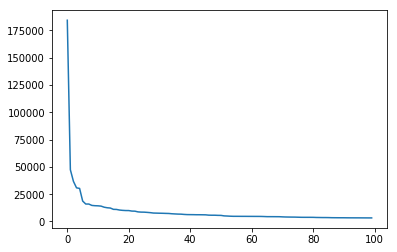

In [0]:
plt.plot(x, frequiences)

In [0]:
import numpy as np

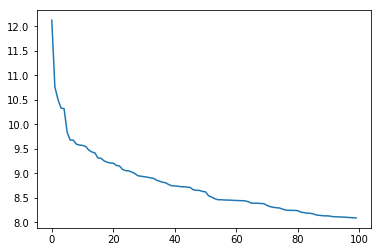

In [0]:
plt.plot(x, np.log(frequiences))

计算单个单词的概率

In [0]:
def prob_1(word):
    return words_count[word] / len(TOKEN)

In [0]:
prob_1('我们')

0.001554473157589251

In [0]:
TOKEN[:10]

['此外', '自', '本周', '6', '月', '12', '日起', '除', '小米', '手机']

In [0]:
TOKEN = [str(t) for t in TOKEN]

In [0]:
TOKEN_2_GRAM = [''.join(TOKEN[i:i+2]) for i in range(len(TOKEN[:-2]))]

In [0]:
TOKEN_2_GRAM[:10]

['此外自', '自本周', '本周6', '6月', '月12', '12日起', '日起除', '除小米', '小米手机', '手机6']

In [0]:
words_count_2 = Counter(TOKEN_2_GRAM)

In [0]:
def prob_1(word): return words_count[word] / len(TOKEN)

计算联合概率

In [0]:
def prob_2(word1, word2):
    if word1 + word2 in words_count_2: return words_count_2[word1+word2] / len(TOKEN_2_GRAM)
    else:
        return 1 / len(TOKEN_2_GRAM)

In [0]:
prob_2('我们', '在')

4.683455274626447e-05

In [0]:
prob_2('在', '吃饭')

2.707199580708929e-07

In [0]:
prob_2('去', '吃饭')

2.707199580708929e-07

求一句话的概率

In [0]:
def get_probablity(sentence):
    words = cut(sentence)# 切词
    
    sentence_pro = 1
    
    for i, word in enumerate(words[:-1]):
        next_ = words[i+1]
        
        probability = prob_2(word, next_)
        
        sentence_pro *= probability
    
    return sentence_pro

In [0]:
get_probablity('小明今天抽奖抽到一台苹果手机')

6.298565169317442e-39

In [0]:
get_probablity('小明今天抽奖抽到一架波音飞机')

3.936603230823401e-40

In [0]:
get_probablity('洋葱奶昔来一杯')

1.9840875058382383e-20

In [0]:
get_probablity('养乐多绿来一杯')

7.3289295697906e-14

In [0]:
for sen in [generate(gram=example_grammar, target='sentence') for i in range(10)]:
    print('sentence: {} with Prb: {}'.format(sen, get_probablity(sen)))

sentence: 这个好看的好看的小小的桌子看见这个蓝色的桌子 with Prb: 2.2164521690859956e-69
sentence: 一个女人听着一个篮球 with Prb: 1.60535263000113e-30
sentence: 一个蓝色的小猫看见这个小小的蓝色的女人 with Prb: 1.449640917029475e-56
sentence: 一个好看的小猫听着这个好看的好看的桌子 with Prb: 2.5600022552943256e-67
sentence: 这个小小的好看的蓝色的篮球看见一个桌子 with Prb: 1.3609128953837052e-55
sentence: 一个篮球听着这个好看的桌子 with Prb: 3.938890259637574e-43
sentence: 这个桌子看着这个好看的小小的小小的篮球 with Prb: 6.347239321041265e-52
sentence: 一个桌子看着这个蓝色的篮球 with Prb: 5.668708652385697e-38
sentence: 一个蓝色的蓝色的好看的桌子听着一个小猫 with Prb: 4.89392638934188e-66
sentence: 一个篮球坐在一个蓝色的好看的小猫 with Prb: 2.538895728416506e-51


In [0]:
need_compared = [
    "今天晚上请你吃大餐，我们一起吃日料 明天晚上请你吃大餐，我们一起吃苹果",
    "真事一只好看的小猫 真是一只好看的小猫",
    "今晚我去吃火锅 今晚火锅去吃我",
    "洋葱奶昔来一杯 养乐多绿来一杯"
]

for s in need_compared:
    s1, s2 = s.split()
    p1, p2 = get_probablity(s1), get_probablity(s2)
    
    better = s1 if p1 > p2 else s2
    
    print('{} is more possible'.format(better))
    print('-'*4 + ' {} with probility {}'.format(s1, p1))
    print('-'*4 + ' {} with probility {}'.format(s2, p2))

明天晚上请你吃大餐，我们一起吃苹果 is more possible
---- 今天晚上请你吃大餐，我们一起吃日料 with probility 1.7051133711305114e-62
---- 明天晚上请你吃大餐，我们一起吃苹果 with probility 1.7051133711305114e-62
真是一只好看的小猫 is more possible
---- 真事一只好看的小猫 with probility 1.599536134964894e-32
---- 真是一只好看的小猫 with probility 5.908452950284614e-26
今晚我去吃火锅 is more possible
---- 今晚我去吃火锅 with probility 8.333167524520602e-19
---- 今晚火锅去吃我 with probility 1.933675511002237e-25
养乐多绿来一杯 is more possible
---- 洋葱奶昔来一杯 with probility 1.9840875058382383e-20
---- 养乐多绿来一杯 with probility 7.3289295697906e-14


**统计所有字**

In [0]:
TOKEN = []

In [0]:
for i, line in enumerate((open('article_9k.txt'))):
#     if i % 100 == 0: print(i)
    
    # replace 10000 with a big number when you do your homework. 
    
#     if i > 10000: break    
    TOKEN += cut(line)

In [0]:
words_count = Counter(TOKEN)

In [0]:
words_count.most_common(100)

[('的', 703716),
 ('n', 382020),
 ('在', 263597),
 ('月', 189330),
 ('日', 166300),
 ('新华社', 142462),
 ('和', 134061),
 ('年', 123106),
 ('了', 121938),
 ('是', 100909),
 ('\n', 89611),
 ('１', 88187),
 ('０', 84945),
 ('外代', 83268),
 ('中', 73926),
 ('中国', 71179),
 ('２', 70521),
 ('2017', 69894),
 ('记者', 62147),
 ('二线', 61998),
 ('将', 61420),
 ('与', 58309),
 ('等', 58162),
 ('为', 57019),
 ('5', 54578),
 ('照片', 52271),
 ('4', 51626),
 ('对', 50317),
 ('上', 47452),
 ('也', 47401),
 ('有', 45767),
 ('５', 40857),
 ('说', 39017),
 ('发展', 37632),
 ('他', 37194),
 ('３', 36906),
 ('以', 36867),
 ('国际', 35842),
 ('nn', 35330),
 ('４', 34659),
 ('比赛', 32232),
 ('６', 30575),
 ('到', 30109),
 ('人', 29572),
 ('从', 29489),
 ('6', 29002),
 ('都', 28027),
 ('不', 27963),
 ('后', 27393),
 ('当日', 27186),
 ('就', 26684),
 ('并', 26568),
 ('国家', 26439),
 ('７', 26386),
 ('企业', 26147),
 ('进行', 25987),
 ('3', 25491),
 ('美国', 25485),
 ('举行', 25389),
 ('被', 25277),
 ('北京', 25245),
 ('体育', 24873),
 ('2', 24376),
 ('1', 24182),
 ('这', 

In [0]:
frequiences = [f for w, f in words_count.most_common(100)]

In [0]:
x = [i for i in range(100)]

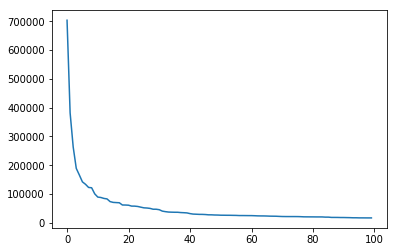

In [0]:
plt.plot(x, frequiences)

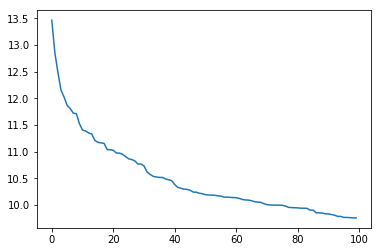

In [0]:
plt.plot(x, np.log(frequiences))

In [0]:
prob_1('我们')

0.0011341645999654677

In [0]:
TOKEN[:10]

['此外', '自', '本周', '6', '月', '12', '日起', '除', '小米', '手机']

In [0]:
TOKEN = [str(t) for t in TOKEN]

In [0]:
TOKEN_2_GRAM = [''.join(TOKEN[i:i+2]) for i in range(len(TOKEN[:-2]))]
TOKEN_2_GRAM[:10]

['此外自', '自本周', '本周6', '6月', '月12', '12日起', '日起除', '除小米', '小米手机', '手机6']

In [0]:
words_count_2 = Counter(TOKEN_2_GRAM)

In [0]:
def prob_1(word): return words_count[word] / len(TOKEN)

In [0]:
def prob_2(word1, word2):
    if word1 + word2 in words_count_2: return words_count_2[word1+word2] / len(TOKEN_2_GRAM)
    else:
        return 1 / len(TOKEN_2_GRAM)

In [0]:
prob_2('我们', '在')

3.0536514065072974e-05

In [0]:
prob_2('在', '吃饭')

2.8379659911777854e-07

In [0]:
prob_2('去', '吃饭')

7.946304775297799e-07

In [0]:
get_probablity('小明今天抽奖抽到一台苹果手机')

1.5046504121058867e-42

In [0]:
get_probablity('小明今天抽奖抽到一架波音飞机')

1.1234723077057287e-41

In [0]:
get_probablity('洋葱奶昔来一杯')

1.8285698188632354e-22

In [0]:
get_probablity('养乐多绿来一杯')

3.2216203868326836e-15

In [0]:
for sen in [generate(gram=example_grammar, target='sentence') for i in range(10)]:
    print('sentence: {} with Prb: {}'.format(sen, get_probablity(sen)))

sentence: 一个小猫听着一个小小的篮球 with Prb: 4.89105006626722e-39
sentence: 一个小小的女人坐在这个蓝色的蓝色的女人 with Prb: 1.3346839266188746e-57
sentence: 这个蓝色的好看的女人坐在这个好看的小猫 with Prb: 3.1342985817706476e-65
sentence: 这个小猫看着一个好看的篮球 with Prb: 7.382818022066217e-41
sentence: 这个小小的蓝色的好看的好看的好看的小猫看见一个小猫 with Prb: 8.084619093062769e-85
sentence: 一个女人听着一个蓝色的蓝色的女人 with Prb: 3.6304009478545493e-54
sentence: 一个小猫听着一个小小的小猫 with Prb: 4.89105006626722e-39
sentence: 一个女人看见一个好看的好看的蓝色的蓝色的小小的女人 with Prb: 8.633331033461073e-83
sentence: 这个好看的好看的好看的好看的小小的蓝色的桌子看见一个小猫 with Prb: 2.170464474165647e-99
sentence: 一个好看的小猫看着这个篮球 with Prb: 6.163048087985711e-40


In [0]:
need_compared = [
    "今天晚上请你吃大餐，我们一起吃日料 明天晚上请你吃大餐，我们一起吃苹果",
    "真事一只好看的小猫 真是一只好看的小猫",
    "今晚我去吃火锅 今晚火锅去吃我",
    "洋葱奶昔来一杯 养乐多绿来一杯"
]

for s in need_compared:
    s1, s2 = s.split()
    p1, p2 = get_probablity(s1), get_probablity(s2)
    
    better = s1 if p1 > p2 else s2
    
    print('{} is more possible'.format(better))
    print('-'*4 + ' {} with probility {}'.format(s1, p1))
    print('-'*4 + ' {} with probility {}'.format(s2, p2))

今天晚上请你吃大餐，我们一起吃日料 is more possible
---- 今天晚上请你吃大餐，我们一起吃日料 with probility 1.8889745916921315e-66
---- 明天晚上请你吃大餐，我们一起吃苹果 with probility 1.5111796733537052e-66
真是一只好看的小猫 is more possible
---- 真事一只好看的小猫 with probility 4.5242555959271015e-34
---- 真是一只好看的小猫 with probility 7.970947520145384e-27
今晚我去吃火锅 is more possible
---- 今晚我去吃火锅 with probility 3.401139863085618e-20
---- 今晚火锅去吃我 with probility 5.396995716765105e-28
养乐多绿来一杯 is more possible
---- 洋葱奶昔来一杯 with probility 1.8285698188632354e-22
---- 养乐多绿来一杯 with probility 3.2216203868326836e-15
